# Chapter 116: QSVT

---

**Prerequisites:**
- See `Chapter02_QuantumSoftware.ipynb` for installation instructions

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit_ibm_runtime import Estimator
from qiskit_aer import Aer
from qiskit.quantum_info import SparsePauliOp
from IPython.display import display
from numpy.polynomial.chebyshev import Chebyshev
from numpy.polynomial import Polynomial
from scipy.sparse import diags
from pyqsp.angle_sequence import QuantumSignalProcessingPhases
from Chapter17_QSVT_functions import (myQSVT,SunderhaufPolynomial,
                                       Wx_to_reflection_phases)

## Chebyshev polynomials

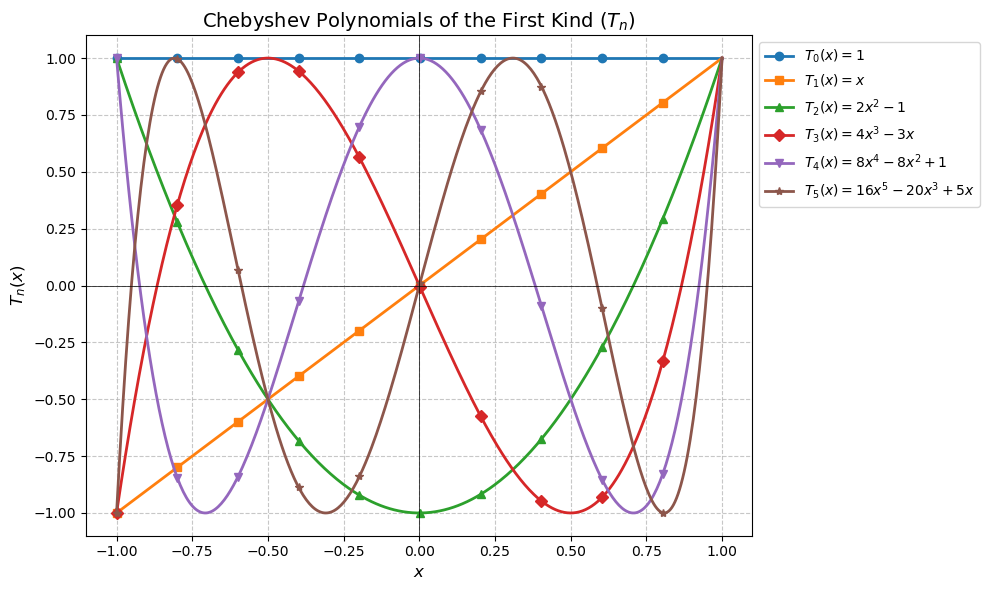

In [2]:
# Define the x range from -1 to 1
x = np.linspace(-1, 1, 400)

# Define the first 6 Chebyshev polynomials
T0 = np.ones_like(x)
T1 = x
T2 = 2*x**2 - 1
T3 = 4*x**3 - 3*x
T4 = 8*x**4 - 8*x**2 + 1
T5 = 16*x**5 - 20*x**3 + 5*x

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x, T0, label='$T_0(x) = 1$', linewidth=2, marker='o', markevery=40)
plt.plot(x, T1, label='$T_1(x) = x$', linewidth=2, marker='s', markevery=40)
plt.plot(x, T2, label='$T_2(x) = 2x^2 - 1$', linewidth=2, marker='^', markevery=40)
plt.plot(x, T3, label='$T_3(x) = 4x^3 - 3x$', linewidth=2, marker='D', markevery=40)
plt.plot(x, T4, label='$T_4(x) = 8x^4 - 8x^2 + 1$', linewidth=2, marker='v', markevery=40)
plt.plot(x, T5, label='$T_5(x) = 16x^5 - 20x^3 + 5x$', linewidth=2, marker='*', markevery=40)

# Formatting the plot
plt.title('Chebyshev Polynomials of the First Kind ($T_n$)', fontsize=14)
plt.xlabel('$x$', fontsize=12)
plt.ylabel('$T_n(x)$', fontsize=12)
plt.axhline(0, color='black', linewidth=0.5) # x-axis
plt.axvline(0, color='black', linewidth=0.5) # y-axis
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.ylim(-1.1, 1.1)
plt.tight_layout()

plt.show()

## Numerically computing phase angles

In [3]:
cheb_coeffs = [0,0,0.5,0,0.1] 
poly = Chebyshev(cheb_coeffs)
phases_wx = QuantumSignalProcessingPhases(poly)
phases_ref = Wx_to_reflection_phases(phases_wx)
print([round(float(phi), 3) for phi in phases_ref])

[-0.732, 0.264, 0.008, 0.264, 0.839]


## From Monomial to Chebyshev

In [4]:
cheb_coeffs = [0,0,0.5,0,0.1] 
poly = Chebyshev(cheb_coeffs)
phases_wx = QuantumSignalProcessingPhases(poly)
phases_ref = np.copy(phases_wx)
phases_ref[0] += np.pi/4
d = len(cheb_coeffs) - 1 # Degree is 4
if d % 2 == 0:
    phases_ref[-1] += np.pi/4
else:
    phases_ref[-1] -= np.pi/4

print("Reflection Phases:")
print([round(float(phi), 3) for phi in phases_ref])

Reflection Phases:
[-0.732, 0.264, 0.008, 0.264, 0.839]


## From Chebyshev to Monomials

In [5]:
# 1. Define the coefficients in the Chebyshev basis
# Let's say we have 1*T_0(x) + 0*T_1(x) + 0.5*T_2(x)
cheb_coeffs = [1, 0, 0.5] 
p_cheb = Chebyshev(cheb_coeffs)

# 2. Convert to the Standard Power basis (Polynomial)
p_standard = p_cheb.convert(kind=Polynomial)

# 3. Output the results
print(f"Chebyshev Polynomial: {p_cheb}")
print(f"Standard Basis Coefficients: {p_standard.coef}")

# Interpretation: 
# T_0 is 1, T_2 is (2x^2 - 1). 
# So: 1(1) + 0.5(2x^2 - 1) = 1 + x^2 - 0.5 = 0.5 + x^2
# Result should be [0.5, 0.0, 1.0]

Chebyshev Polynomial: 1.0 + 0.0 T_1(x) + 0.5 T_2(x)
Standard Basis Coefficients: [0.5 0.  1. ]


## SVD

In [6]:
A = np.array([[0.1, 0.2], [0.2, 0.4]])
U, S, Vh = np.linalg.svd(A,compute_uv=True)

print("Singular values of A:", S)
print("Left singular vectors (U):", U)
print("Right singular vectors (Vh):", Vh)

Singular values of A: [5.00000000e-01 2.64734348e-17]
Left singular vectors (U): [[-0.4472136  -0.89442719]
 [-0.89442719  0.4472136 ]]
Right singular vectors (Vh): [[-0.4472136  -0.89442719]
 [-0.89442719  0.4472136 ]]


## SVD always exists

In [7]:
A = np.array([[2, 1], [0, 2]])
U, S, Vh = np.linalg.svd(A,compute_uv=True)

print("Singular values of A:\n", S)
print("Left singular vectors (U):\n", U)
print("Right singular vectors (Vh):\n", Vh)

print("A ~ \n", U @ np.diag(S) @ Vh)  # Reconstruct A

Singular values of A:
 [2.56155281 1.56155281]
Left singular vectors (U):
 [[ 0.78820544 -0.61541221]
 [ 0.61541221  0.78820544]]
Right singular vectors (Vh):
 [[ 0.61541221  0.78820544]
 [-0.78820544  0.61541221]]
A ~ 
 [[ 2.00000000e+00  1.00000000e+00]
 [-1.80064996e-16  2.00000000e+00]]


## Sunderhauf approximation

In [8]:
eps = 0.01
delta = 0.01

# Compute optimal degree
d = SunderhaufPolynomial.mindegree(eps, delta)
print(f"Optimal degree: {d}")  

# Get Chebyshev polynomial
cheb_poly = SunderhaufPolynomial.poly(d, delta)
scaling_factor = 0.9*delta 
cheb_poly_scaled = cheb_poly * scaling_factor

#print(f"Chebyshev polynomial\n", cheb_poly_scaled)


Optimal degree: 921


## Plot the two functions

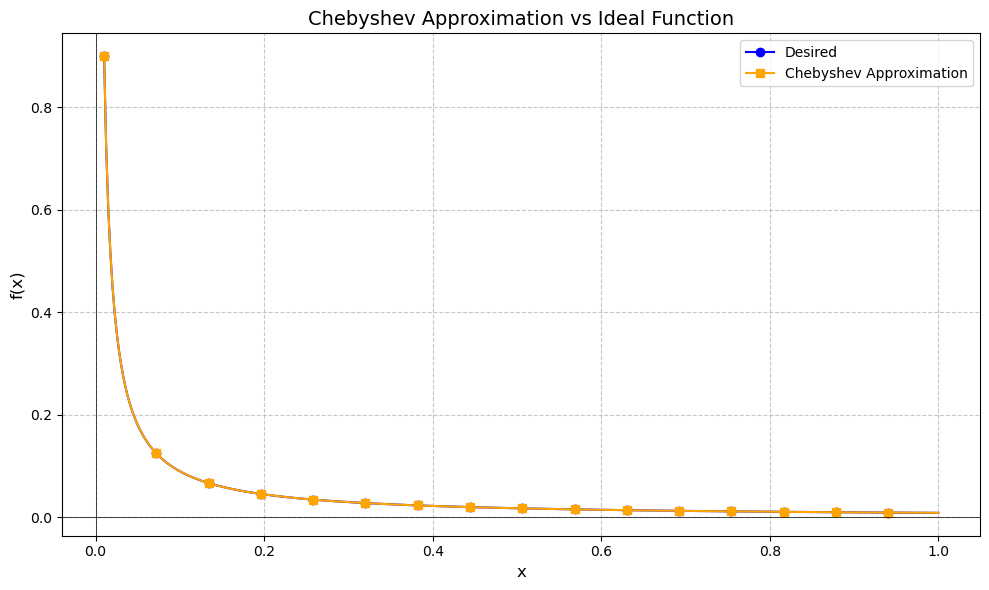

In [9]:
x = np.linspace(delta, 1, 400)
fx = scaling_factor/x
plt.figure(figsize=(10, 6))
plt.plot(x, fx, label='Desired', color='blue', marker='o', markevery=25)
plt.plot(x, cheb_poly_scaled(x), label=f'Chebyshev Approximation', color='orange', marker='s', markevery=25)
plt.title('Chebyshev Approximation vs Ideal Function', fontsize=14) 
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.axhline(0, color='black', linewidth=0.5) # x
plt.axvline(0, color='black', linewidth=0.5) # y
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

## Choose from Ax = b examples

In [20]:
example = 2
if (example == 1):
	A = np.array([[1,0],[0,1]]) 
	b = np.array([1,0])
elif (example == 2):
	A = np.array([[2,-1],[-1,2]])
	b = np.array([1,1])/np.sqrt(2)
elif (example == 3):
	A = np.array([[1,0,0,-0.5],[0,1,0,0],[0,0,1,0],[-0.5,0,0,1]])
	b = np.array([1,0,0,0])
elif (example == 4):
	A = np.array([[1.5,0.5],[0.5,1.5]])
	b = np.array([1,0])
elif (example == 5):
	p = 1
	A = np.array([[5*(10**p),-1],[-1,5]])
	b = np.array([1,0])
elif (example == 6):
	N = 2**2
	values = [-np.ones(N-1),2*np.ones(N),-np.ones(N-1)]
	A = diags(values,[-1,0,1]).toarray()
	b = np.zeros(N)
	b[0] = 1

print("A:\n", A)
print("b:\n", b)

A:
 [[ 2 -1]
 [-1  2]]
b:
 [0.70710678 0.70710678]


## Inversion

In [21]:
A = np.array([[0.5, -0.25], [-0.25, 0.5]])
sigma_vals = np.linalg.svd(A, compute_uv=False)
A = A / (1.1*np.max(sigma_vals))  # Scale to have max singular value = 1
sigma_vals = np.linalg.svd(A, compute_uv=False)
print("Singular values of A:", sigma_vals)
kappa = np.max(sigma_vals) / np.min(sigma_vals)
print(f"Condition number kappa={kappa}")
solver = myQSVT(A, b, kappa, nShots=1000, target_error=0.01)

u_qsvt = solver.solve()
print("QSVT Solution (|x>):", u_qsvt)
# Classical Verification
x_exact = np.linalg.solve(A, b)
u_exact = x_exact / np.linalg.norm(x_exact)
print("Classical Solution: ", u_exact)
print("Fidelity:           ", np.abs(np.dot(u_qsvt.conj(), u_exact))**2)

Singular values of A: [0.90909091 0.3030303 ]
Condition number kappa=3.000000000000001
Singular values: [0.90909091 0.3030303 ]
Optimal degree for ε=1.00e-02: 17
Polynomial maximum: 3.6120
After normalization, max value: 0.998025
Generated 18 angles for degree 17
Circuit width: 4, depth: 37
Running QSVT circuit on statevector simulator...
QSVT Solution (|x>): [0.70710678+0.00000000e+00j 0.70710678-1.65591525e-16j]
Classical Solution:  [0.70710678 0.70710678]
Fidelity:            1.0
